# Projekt 1 – perceptron Rosenblatta

## Temat: płytka sieć do nauki problemu XOR

## Tasks:
### Waiting

* Wykresy błędu MSE (błędu średniokwadratowego) w obu warstwach (na przykładach uczących oraz na całym zbiorze uczącym):

    - dla całego ciągu uczącego 


* Dodać opisy zdjęć - skąd są
* ujednolicić nazwy zmiennych

* Opis zaimplementowanych funkcji - dopieścić
* Opis zaimplementowanych zmiennych i stałych - eze


### In progres


### Ready


### Done
* Zaimplelentować mini - batche 
* Wykresy błędu MSE    - dla warstwy ukrytej MSE
* Wykresy błędu MSE - dla przykładu uczącego
* szybsze kończenie uczenia przy spadku MSE poniżej zadanej wartości
* wykresy błędu klasyfikacji
* wykresy błędu klasyfikacji (przyjmujemy próg 0.5 dla klasyfikacji 0-1)
* Krótki opis problemu
* wykresy wag w obu warstwach.


<!-- ### To do - jak wystarczy czasu - pewnie nie wystarczy:

* dodanie momentum,
* adaptacyjny współczynnik uczenia, -->



### Opis Problemu - MLP for XOR problem
Problem XOR (Exclusive OR) stanowi kluczowy problem w uczeniu maszynowym, który ilustruje wyzwania związane z tworzeniem modeli opartych na neuronach lub sieciach neuronowych.

XOR to logiczna operacja, która zwraca prawdę (1) tylko wtedy, gdy jedno z wejść jest prawdziwe, a drugie fałszywe.

![Bramka XOR](./photos/XOR_tabela_prawdy.png)


Problem polega na tym, że XOR nie jest liniowo separowalny - oznacza to, że nie można podzielić przestrzeni wejść linią (linią prostą w dwóch wymiarach lub płaszczyzną w trzech wymiarach), aby poprawnie oddzielić przypadki prawdziwe od fałszywych.

![Przestrzeń cech XOR](./photos/XOR_przestrzen_wejsc.png)



Tradycyjne modele liniowe, takie jak regresja logistyczna czy perceptron, nie są w stanie modelować funkcji XOR, ponieważ nie mogą stworzyć odpowiedniego podziału przestrzeni wejść. Jednak sieci neuronowe z warstwą ukrytą potrafią rozwiązać ten problem poprzez tworzenie nieliniowych kombinacji wejść. Wprowadzenie warstwy ukrytej pozwala na stworzenie odpowiednich granic decyzyjnych w przestrzeni cech, umożliwiając modelowi na nauczenie się funkcji XOR.

![Rozwiązanie XOR za pomocą MLP](./photos/rozw_problemuXOR_MLP.png)



W celu sprawnego nauczenia sieci i przedstawienia skondensowanych wyników, sieć domyślnie jest uczona 4 przypadków jednocześnie, tj zbierane są gradienty dla każdego przypdadku wejścia XOR i zmiany dW1, db1, dW2, db2 są wszystkie nakładane jednocześnie.  

In [157]:
import numpy as np
#import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime

In [158]:
plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [159]:
now = datetime.now().second # trochę bardziej losowe generowanie seeda
np.random.seed(now) # on był pseudo losowy celowo XD

In [160]:
def get_data_batch(X,Y,batch):
    X_ = []
    Y_ = []
    for _ in range(0,batch):
        #print(X)
        X_.append(X[0])
        X = np.delete(X,0,0)
        if len(X) == 0:
            X = np.array([[0,0],[0,1],[1,0],[1,1]])
        Y_.append(Y[0])
        Y = np.delete(Y,0,0)
        if len(Y) == 0:
            Y = np.array([[0],[1],[1],[0]])
    
    return X, Y, np.array(X_),np.array(Y_)


In [161]:
# funkcja aktywacji używana dla każdego neuronu
def sigmoid(x): 
	return 1.0/(1.0 + np.exp(-x))
# pochodna funkcji aktywacji używana przy obliczaniu wag w propagacji wstecznej
def sigmoid_prime(x): 
    return x * (1 - x)

In [162]:
# inicjalizacja wag i baiasów
def initialize_params():
    W1 = np.random.rand(2, 2) - 0.5
    b1 = np.random.rand(1, 2) - 0.5
    W2 = np.random.rand(2, 1) - 0.5
    b2 = np.random.rand(1, 1) - 0.5
    return W1, b1, W2, b2

In [163]:
# funkcja odpowiedzialna za przeprowadzenie obliczeń sieci opartych na wejściu (X) oraz na Wagach(W1,W2) i bajasach (b1,b2)
def forward_prop(W1, b1, W2, b2, X):
    Z1 = np.dot(X,W1) + b1
    A1 = sigmoid(Z1)
    
    Z2 = np.dot(A1,W2) + b2
    A2 = sigmoid(Z2)
    
    return A1, A2

# funkcja przeprowadzająca proces wstecznej propagacji za pomocą której obliczane są gradienty i zmiany jakie muszą być dodane do Wag i bajasów 
def backward_prop(A1, A2, W1, W2, X, Y, lr): 
    dA2 = Y - A2 # Pochodna będu MSE
    dZ2 = dA2 * sigmoid_prime(A2)
    
    dA1 = dZ2.dot(W2.T) # błąd 1. warstwy (ukrytej)
    dZ1 = dA1 * sigmoid_prime(A1) # błąd neuronów w 1. warstwie (ukrytej)

    return dA2, dZ2, dA1, dZ1

def calculate_corrections(X, A1, dZ1, dZ2, lr):
    dW1 = lr * X.T.dot(dZ1)
    db1 = lr * np.sum(dZ1,axis=0,keepdims=True)
    
    dW2 = lr * A1.T.dot(dZ2) 
    db2 = lr * np.sum(dZ2,axis=0,keepdims=True)

    return dW1, db1, dW2, db2




In [164]:
# zwraca błąd klasyfikacji
def classification_error(Y,A2):
    C = np.abs(Y - A2) > 0.5
    return C.sum()/Y.size

In [165]:
# def get_predictions(A2):
### TO DO

# def get_accuracy(predictions, Y):
### TO DO

def gradient_descent(X, Y, lr, iterations, logs = True, batch_size = 2, mse_threshold = 0.005):
    W1, b1, W2, b2 = initialize_params()# funkcja zwraca wagi i bajasy używane w sieci
    CE = []
    MSE2 = []
    MSE1 = []
    Ws1 = [W1]
    bs1 = [b1]
    Ws2 = [W2]
    bs2 = [b2]
    Xsave = X
    Ysave = Y
    for i in range(iterations):
        Xsave, Ysave, X,Y = get_data_batch(Xsave,Ysave,batch_size)
        A1, A2 = forward_prop(W1, b1, W2, b2, X)# Funkcja zwraca poziomy katywacji dla bydwu warstw

        dA2, dZ2, dA1, dZ1 = backward_prop( A1, A2, W1, W2, X, Y, lr)
        dW1, db1, dW2, db2 = calculate_corrections(X, A1, dZ1, dZ2, lr)
        
        MSE2_current = np.mean(dA2 ** 2)
        MSE2.append(MSE2_current)
        MSE1.append(np.mean(dA1 ** 2))
        
        
        W1 = W1 + dW1
        b1 = b1 + db1 
        W2 = W2 + dW2 
        b2 = b2 + db2
        
        Ws1.append(W1)
        bs1.append(b1)
        Ws2.append(W2)
        bs2.append(b2)
        
        
        CE.append(classification_error(Y,A2))
        if i % 1000 == 0 and logs:
            print("Iteration: ", i)
            print(A2.T)
            print(Y.T)
        if MSE2_current <= mse_threshold:
            break
    print("Final Predictions")
    print(A2.T)
    print(Y.T)
    return W1, b1, W2, b2, CE, MSE1, MSE2, Ws1, bs1, Ws2, bs2

In [171]:
X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[0],[1],[1],[0]])     
W1, b1, W2, b2, CE, MSE1, MSE2, Ws1, bs1, Ws2, bs2 = gradient_descent(X, Y, 0.2, 30000, logs = False, batch_size = 1, mse_threshold = 0.005)

Final Predictions
[[0.07068553]]
[[0]]


### Błąd klasyfikacji CE

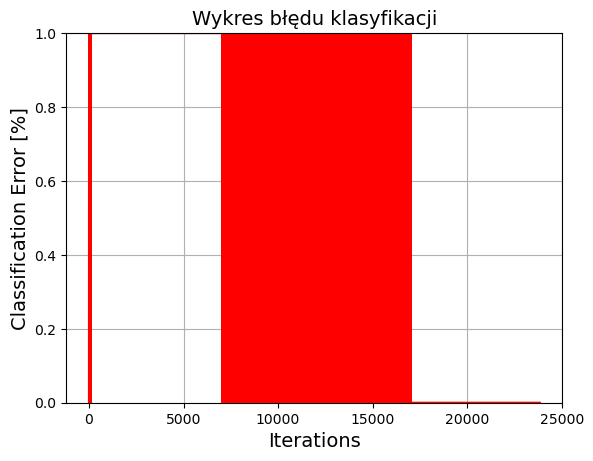

In [172]:
plt.plot(CE,'r')
plt.xlabel('Iterations')
plt.ylabel('Classification Error [%]')
plt.ylim([0, 1])
plt.title('Wykres błędu klasyfikacji')
plt.grid(True)
plt.show()

### Błąd średniokwadratowy MSE

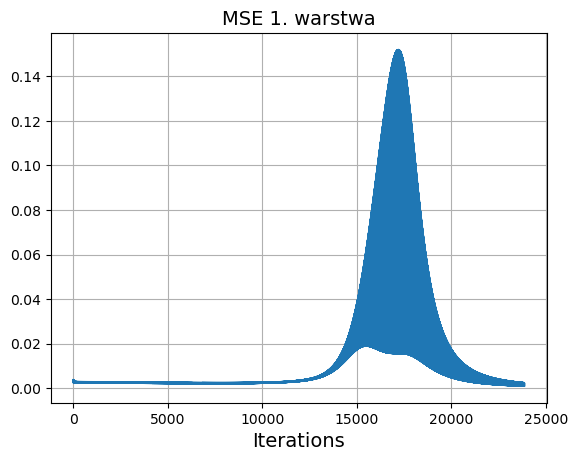

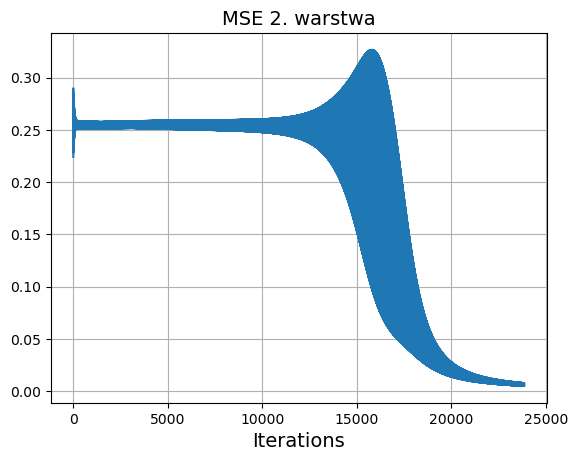

In [173]:
plt.plot(MSE1)

plt.xlabel('Iterations')
plt.ylabel('')
plt.title('MSE 1. warstwa')
plt.grid(True)
plt.show()

plt.plot(MSE2)

plt.xlabel('Iterations')
plt.ylabel('')
plt.title('MSE 2. warstwa')
plt.grid(True)
plt.show()


### Wagi i bajasy

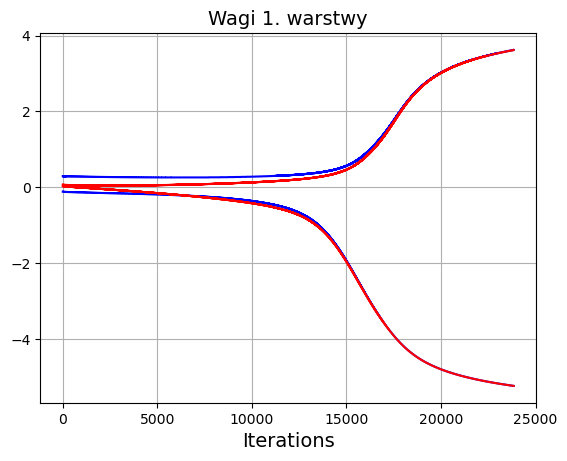

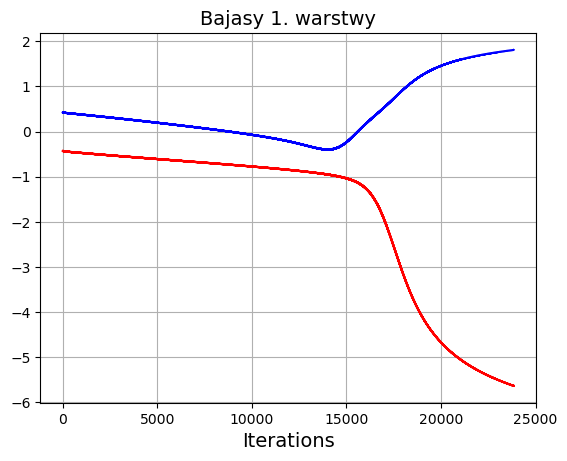

In [174]:
plt.plot([Ws1[n][0]for n in range(0,len(Ws1))],'b')
plt.plot([Ws1[n][1] for n in range(0,len(Ws1))],'r')
plt.xlabel('Iterations')
plt.ylabel('')
plt.title('Wagi 1. warstwy')
plt.grid(True)
plt.show()

plt.plot([[bs1[n][0][0]] for n in range(0,len(bs1))],'b')
plt.plot([[bs1[n][0][1]] for n in range(0,len(bs1))],'r')

plt.xlabel('Iterations')
plt.ylabel('')
plt.title('Bajasy 1. warstwy')
plt.grid(True)
plt.show()

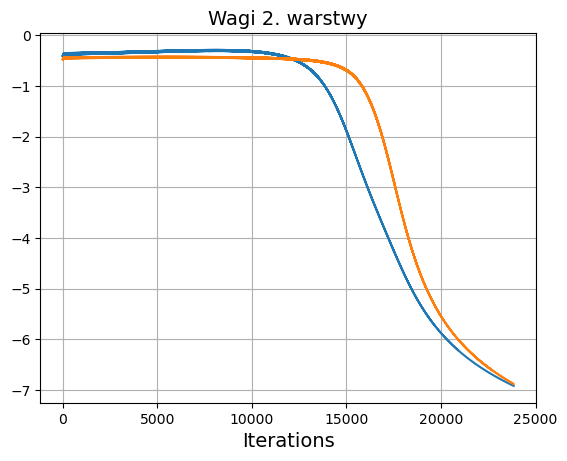

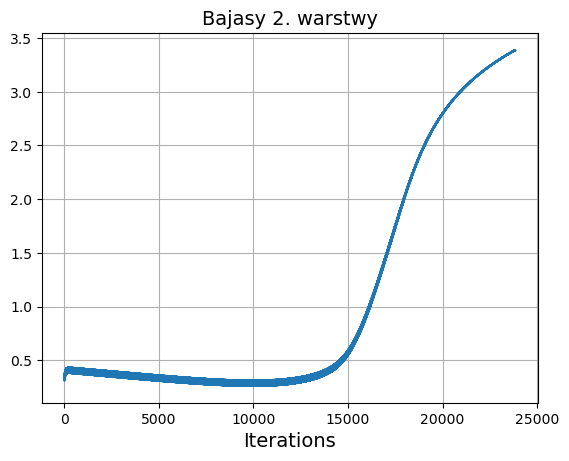

In [175]:
plt.plot([np.concatenate((Ws2[n][0],Ws2[n][1]),axis=0) for n in range(0,len(Ws2))])
plt.xlabel('Iterations')
plt.ylabel('')
plt.title('Wagi 2. warstwy')
plt.grid(True)
plt.show()

plt.plot([bs2[n][0] for n in range(0,len(Ws2))])

plt.xlabel('Iterations')
plt.ylabel('')
plt.title('Bajasy 2. warstwy')
plt.grid(True)
plt.show()